# Picture Analytics Character Detection

# Helper Functions

In [12]:
import cv2
import json
import requests
import urllib3
from IPython.display import *

urllib3.disable_warnings()
s = requests.Session()
dora_url = "https://129.40.124.167/powerai-vision/api/dlapis/e7de9042-fc59-41af-94c7-67c21cbe3920"
spongebob_url = "https://129.40.124.167/powerai-vision/api/dlapis/1eb747e7-af21-4b6d-8ebd-fb5e6e60be00"
darthvader_url = "https://129.40.124.167/powerai-vision/api/dlapis/11fa820e-65c6-4af6-87c8-4549970d5d08"
woody_url = "https://129.40.124.167/powerai-vision/api/dlapis/093f56e6-28c5-4754-9ca4-d4687fc581e6"
    
WHITE = (255, 255, 255)
YELLOW = (66, 244, 238)
GREEN = (80, 220, 60)
LIGHT_CYAN = (255, 255, 224)
DARK_BLUE = (139, 0, 0)
GRAY = (128, 128, 128)

def detect_objects(filename, model_url):

    with open(filename, 'rb') as f:
        # WARNING! verify=False is here to allow an untrusted cert!
        r = s.post(model_url,
                   files={'files': (filename, f)},
                   verify=False)

    return r.status_code, json.loads(r.text)

def label_object(color, textcolor, fontface, image, label, textsize, thickness, xmax, xmid, xmin, ymax, ymid, ymin):
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, thickness)
    pos = (xmid - textsize[0]//2, ymid + textsize[1]//2)
    cv2.putText(image, label, pos, fontface, 1, textcolor, thickness, cv2.LINE_AA)

def score_frames(result, filename):
    img = cv2.imread(filename)
    for obj in result:
            ymin = obj.get("ymin", "")
            ymax = obj.get("ymax", "")
            ymid = int(round((ymin+ymax)/2))
            xmin = obj.get("xmin", "")
            xmax = obj.get("xmax", "")
            xmid = int(round((xmin+xmax)/2))
            label = obj.get("label", "")
            fontface = cv2.FONT_HERSHEY_SIMPLEX
            fontscale = 1
            thickness = 1
            textsize, _baseline = cv2.getTextSize(
             label, fontface, fontscale, thickness)
            label_object(GREEN, YELLOW, fontface, img, label, textsize, 4, xmax, xmid, xmin, ymax, ymid, ymin)

    cv2.imwrite("output/output-" + filename.split('/')[5], img)
    frame = cv2.imread("output/output-" + filename.split('/')[5])
    clear_output(wait=True)
    rows, columns, _channels = frame.shape
    frame = cv2.resize(frame, (int(columns/2), int(rows/2)))  # shrink it
    _ret, jpg = cv2.imencode('.jpg', frame)
    display(Image(data=jpg))            


# Convert List from Spectrum Discover into Filelist

In [22]:
import csv
def get_filelist(discover_report, character, location):
    file_list = []
    with open(discover_report) as file:
        reader = csv.reader(file)
        for row in reader:
            if (row[28]==character) and (location in row[0]) and (("jpg" in row[2]) or ("jpeg" in row[2]) or ("png" in row[2])):
                file_list.append(''.join([row[0], row[1]]))
    return file_list

In [24]:
file_list = get_filelist('get_character_locations.csv', 'dora', 'test')
print(file_list)

['/gpfs/b9t020a07/dora/test/dora_test6.jpg', '/gpfs/b9t020a07/dora/test/dora_test13.jpg', '/gpfs/b9t020a07/dora/test/dora_test4.jpg', '/gpfs/b9t020a07/dora/test/dora_test5.jpg', '/gpfs/b9t020a07/dora/test/dora_test1.jpg', '/gpfs/b9t020a07/dora/test/dora_test2.jpg', '/gpfs/b9t020a07/dora/test/dora_test3.jpg', '/gpfs/b9t020a07/dora/test/dora_test14.jpg', '/gpfs/b9t020a07/dora/test/dora_test8.jpg', '/gpfs/b9t020a07/dora/test/dora_test11.jpg', '/gpfs/b9t020a07/dora/test/dora_test9.jpg', '/gpfs/b9t020a07/dora/test/dora_test10.jpg', '/gpfs/b9t020a07/dora/test/dora_test7.jpg', '/gpfs/b9t020a07/dora/test/dora_test12.jpg']


# Run Inference and Cache All Results

In [15]:
def run_inference(file_list, test_dir, object_url):
    # Serialize requests, storing them in a "tracking_results" dict

    try:
        with open('cache-results.json') as existing_results:
            cache_results = json.load(existing_results)
    except Exception:
        # Any fail to read existing results means we start over
        cache_results = {}
    full_path_list =[]
    i = 0
    cache_used = 0
    sampled = 0
    for filename in file_list:
        i += 1
        filename = test_dir + filename
        full_path_list.append(filename)
        existing_result = cache_results.get(filename)
        if existing_result and existing_result['result'] == 'success':
            cache_used += 1
        else:
            rc, results = detect_objects(filename, object_url)
            if rc != 200 or results['result'] != 'success':
                print("ERROR rc=%d for %s" % (rc, filename))
                print("ERROR result=%s" % results)
            else:
                # Save frequently to cache partial results
                cache_results[filename] = results
                with open('cache-results.json', 'w') as fp:
                    json.dump(cache_results, fp)

        print("Processed file {num} (used cache {cache_used} times)".format(
            num=i, cache_used=cache_used), end="\r")

    # Finally, write all our results
    with open('cache-results.json', 'w') as fp:
        json.dump(cache_results, fp)

    print("\nDone")
    return full_path_list

# Demo

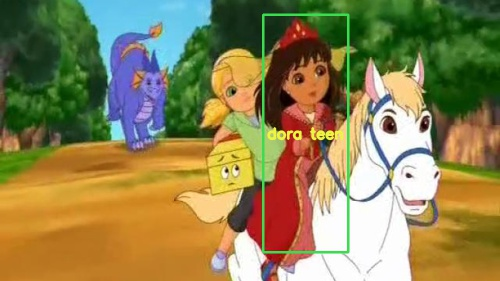

Processed file number 14
Done


In [25]:
import glob
import os

files = glob.glob("output/*")
print("DELETING "+"output/*")
for f in files:
    os.remove(f)

if os.path.exists("cache-results.json"):
    os.remove("cache-results.json")

file_list = get_filelist('get_character_locations.csv', 'dora', 'test')
print(file_list)

file_list = run_inference(file_list, "", dora_url)
#print(file_list)

counter = 0
with open('cache-results.json') as existing_results:
    sample_frames = json.load(existing_results)



for filename in file_list:
    counter += 1
        #img = cv2.imread(filename)
    if filename in sample_frames and 'classified' in sample_frames[filename]:
        objects = sample_frames[filename]['classified'] 
        for i in objects:
#                label = i.get("label", "")
#                confidence = i.get("confidence", "")
#                print(label, "w/ prediction score:",confidence)
            boxes= score_frames(objects, filename)
        print("Processed file number", counter)
print("Done")

# Create a video from the annotated frames

In [26]:
if os.path.exists("out.mp4"):
    os.remove("out.mp4")
!ffmpeg -y -loglevel panic -framerate 1 -pattern_type glob -i 'output/*.jpg' -vcodec mpeg4 -r 30 -pix_fmt yuv422p out.mp4

In [ ]:
import io
import base64
from IPython.display import HTML

video = io.open('out.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

# Update File Metadata

In [27]:
import csv

with open('cache-results.json') as existing_results:
    sample_frames = json.load(existing_results)

with open('metadata.csv', 'w') as metadata:
    writer = csv.writer(metadata)
    
    for filename in file_list:
        
        labels =""
            
        if filename in sample_frames and 'classified' in sample_frames[filename]:
            objects = sample_frames[filename]['classified'] 
            for i in objects:
                confidence = i.get("confidence", "")
                label = i.get("label", "") + " " + "(" + str(round((confidence*100),2)) + "%)"
                if (labels == ''):
                    labels = label
                else:
                    labels = labels + " " + label
            new_row = [filename, labels]
            writer.writerow(new_row)
            command = 'mmchattr --set-attr user.labels=' + '"' + labels + '"' + " " + filename
            os.system(command)
            print("found " + labels + " in "+ filename)
            #print(command)
print("Done")

found dora lookalike (66.66%) dora (81.74%) in /gpfs/b9t020a07/dora/test/dora_test6.jpg
found dora lookalike (96.86%) in /gpfs/b9t020a07/dora/test/dora_test13.jpg
found dora lookalike (98.4%) dora (94.76%) in /gpfs/b9t020a07/dora/test/dora_test4.jpg
found dora lookalike (97.51%) in /gpfs/b9t020a07/dora/test/dora_test5.jpg
found dora lookalike (97.08%) in /gpfs/b9t020a07/dora/test/dora_test1.jpg
found dora (73.6%) in /gpfs/b9t020a07/dora/test/dora_test2.jpg
found  in /gpfs/b9t020a07/dora/test/dora_test3.jpg
found dora lookalike (94.45%) in /gpfs/b9t020a07/dora/test/dora_test14.jpg
found dora lookalike (77.75%) dora (66.51%) in /gpfs/b9t020a07/dora/test/dora_test8.jpg
found dora (73.14%) in /gpfs/b9t020a07/dora/test/dora_test11.jpg
found dora (96.17%) in /gpfs/b9t020a07/dora/test/dora_test9.jpg
found dora (66.04%) dora movie (79.68%) in /gpfs/b9t020a07/dora/test/dora_test10.jpg
found dora lookalike (97.33%) dora movie (93.93%) in /gpfs/b9t020a07/dora/test/dora_test7.jpg
found dora teen (